In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import keras
keras.__version__
import numpy as np
import os, shutil

Using TensorFlow backend.


## Convolutional Neural Networks - Classifying Cats and Dogs

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: https://www.kaggle.com/c/dogs-vs-cats/data (you will need to create a Kaggle account if you don't already have one -- don't worry, the process is painless).

The pictures are medium-resolution color JPEGs. They look like this:


<img src="cats_dogs.jpg" width="500">

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. In our own example, we will get fairly close to this accuracy, even though we will be training our models on less than 10% of the data that was available to the competitors. This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). We will be using a subset of the data containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.

In [2]:
# Define directories of where the training, validation and test sets reside
# This is the path to where my files are - your path will be different
base_dir = '/Users/heathermattie/Dropbox/Teaching/2019/BST261/cats_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(base_dir, 'train/cats')
train_dogs_dir = os.path.join(base_dir, 'train/dogs')
validation_cats_dir = os.path.join(base_dir, 'validation/cats')
validation_dogs_dir = os.path.join(base_dir, 'validation/dogs')
test_cats_dir = os.path.join(base_dir, 'test/cats')
test_dogs_dir = os.path.join(base_dir, 'test/dogs')

In [3]:
# Let's check the number of images in each set
print('Total training cat images:', len(os.listdir(train_cats_dir)))
print('Total training dog images:', len(os.listdir(train_dogs_dir)))
print('Total validation cat images:', len(os.listdir(validation_cats_dir)))
print('Total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('Total test cat images:', len(os.listdir(test_cats_dir)))
print('Total test dog images:', len(os.listdir(test_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500
Total test cat images: 500
Total test dog images: 500


### Creating a CNN from scratch

We've already built a small CNN for MNIST in the previous lecture, so you should be familiar with them. We will reuse the same general structure: our CNN will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more Conv2D + MaxPooling2D stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the Flatten layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the Flatten layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all CNNs.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [15]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

We can check out our model architecture using the following `.summary` command:

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [17]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

1. Read the picture files.
2. Decode the JPEG content to RBG grids of pixels.
3. Convert these into floating point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at keras.preprocessing.image. In particular, it contains the class `ImageDataGenerator` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size = (150, 150),
        batch_size = 20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point.

In [19]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of fit for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-samples large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a validation_data argument, much like with the fit method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of numpy arrays as well. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 48s 475ms/step - loss: 0.6863 - acc: 0.5475 - val_loss: 0.6995 - val_acc: 0.5200
Epoch 2/30
100/100 [==============================] - 45s 452ms/step - loss: 0.6579 - acc: 0.6115 - val_loss: 0.6645 - val_acc: 0.5880
Epoch 3/30
100/100 [==============================] - 46s 455ms/step - loss: 0.6087 - acc: 0.6765 - val_loss: 0.6270 - val_acc: 0.6430
Epoch 4/30
100/100 [==============================] - 47s 475ms/step - loss: 0.5749 - acc: 0.7045 - val_loss: 0.6011 - val_acc: 0.6610
Epoch 5/30
100/100 [==============================] - 46s 458ms/step - loss: 0.5436 - acc: 0.7255 - val_loss: 0.5872 - val_acc: 0.6860
Epoch 6/30
100/100 [==============================] - 44s 440ms/step - loss: 0.5179 - acc: 0.7535 - val_loss: 0.6020 - val_acc: 0.6660
Epoch 7/30
100/100 [==============================] - 45s 451ms/step - loss: 0.4831 - acc: 0.7630 - val_loss: 0.5909 - val_acc: 0.6840
Epoch 8

CNNs typically take much longer to run than other deep networks, so it's always a good idea to save the model after you train it.

In [21]:
model.save('cats_and_dogs_small_1.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: **data augmentation**.

### Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

`rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.

`width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

`shear_range` is for randomly applying shearing transformations.

`zoom_range` is for randomly zooming inside pictures.

`horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).

`fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

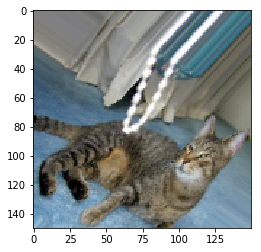

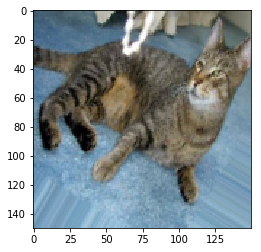

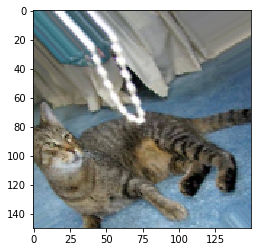

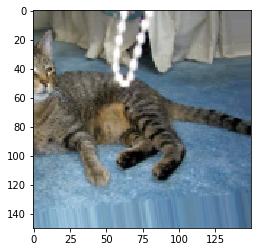

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [11]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100


In [ ]:
model.save('cats_and_dogs_small_2.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a **pre-trained model**.

### Using Pre-trained Models
A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will cover both of them. Let's start with feature extraction.

#### Feature Extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, CNNs used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the `"convolutional base"` of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


We passed three arguments to the constructor:

`weights`, to specify which weight checkpoint to initialize the model from

`include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.

`input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

At this point, there are two ways we could proceed:

1. Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

2. Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of conv_base on our data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the predict method of the `conv_base` model.

#### Feature extraction **without** data augmentation

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6020 - acc: 0.6705 - val_loss: 0.4558 - val_acc: 0.8150
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4334 - acc: 0.8030 - val_loss: 0.3739 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.3595 - acc: 0.8440 - val_loss: 0.3308 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3212 - acc: 0.8670 - val_loss: 0.3053 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.2902 - acc: 0.8835 - val_loss: 0.2885 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2662 - acc: 0.8955 - val_loss: 0.2749 - v

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


We reach a validation accuracy of about 90%, much better than what we could achieve with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

#### Feature extraction **with** data augmentation
Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. **"Freezing"** a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [8]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [9]:
conv_base.trainable = False

In [10]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
model.save('cats_and_dogs_small_3.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine-tuning
Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

1) Add your custom network on top of an already trained base network.

2) Freeze the base network.

3) Train the part you added.

4) Unfreeze some layers in the base network.

5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our conv_base, and then freeze individual layers inside of it.

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.
Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 558s 6s/step - loss: 0.4065 - acc: 0.8245 - val_loss: 0.2596 - val_acc: 0.8930
Epoch 2/100
100/100 [==============================] - 561s 6s/step - loss: 0.1961 - acc: 0.9280 - val_loss: 0.2094 - val_acc: 0.9140
Epoch 3/100
100/100 [==============================] - 553s 6s/step - loss: 0.1276 - acc: 0.9575 - val_loss: 0.2038 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 546s 5s/step - loss: 0.0864 - acc: 0.9765 - val_loss: 0.1824 - val_acc: 0.9260
Epoch 5/100
100/100 [==============================] - 545s 5s/step - loss: 0.0525 - acc: 0.9875 - val_loss: 0.2063 - val_acc: 0.9190
Epoch 6/100
 99/100 [============================>.] - ETA: 3s - loss: 0.0332 - acc: 0.9939

In [ ]:
model.save('cats_and_dogs_small_4.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

### CNNs with small data sets take-aways:

* CNNs are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.

* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.

* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.

* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.